# Assignment 7: Dogs vs Cats

In this assignment, Our data set was 25,000 images of dogs and cats. The images were stored in two separate zip files. One of the challenges with this dataset, is that the images are all 224x224 pixels, and due to computational issues, these images were reduced to size 64x64. Cats were classified with a 0, and Dogs were classfied with a 1.

All 4 models followed a similar pattern: two layers of convolution followed by a pooling layer and a 25% drop out rate. Afterwards there was a flatten layer and a dense layer before the soft max layer.

Model 1 consists of 32 nodes in the convolution layer. This model earned a Kaggle score of .71.

Model 2 conists of 32 nodes in the convolution layer, followed by 64 nodes in the convolution layer. This model earned a Kaggle score of .692.

Model 3 consists of 64 nodes in the convolution layer. This model earned a Kaggle score of .75

Model 4 conists of 16 nodes in the convolution layer, followed by 32 nodes in the convolution layer. This model earned a Kaggle score of .693.

If I was providing advice to a website, I would consider using some of the more sophisticated CNN architectures out there, like ResNet, GoogLeNet, and VGGNet. If training time is cut down then, maybe lower resolution images will be required to help the models run faster. Alot of the time is dependent on the hardware and ram the computer has. This was a limiting factor in my case.

The data for this notebook can be downloaded on Kaggle here: https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

# Directory and Package Loading

In [0]:
# Set the directory to the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
!ls "/content/drive/My Drive"

 403				     'submission_2 assignment 5.csv'
'Colab Notebooks'		      test.csv
 dogs-vs-cats-redux-kernels-edition   train.csv
'submission_1 assignment 5.csv'


In [0]:
import os, cv2, random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
from random import shuffle 
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.applications import ResNet50
import tensorflow
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Dropout 
%matplotlib inline 

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


# Import Images

In [0]:
TEST_SIZE = 0.5
RANDOM_STATE = 2018
BATCH_SIZE = 16
NO_EPOCHS = 5
NUM_CLASSES = 2
SAMPLE_SIZE = 20000
PATH = '/content/drive/My Drive/dogs-vs-cats-redux-kernels-edition/'
TRAIN_FOLDER = './train/'
TEST_FOLDER =  './test/'
IMG_SIZE = 224
NEW_IMG_SIZE = 64

In [0]:
train_image_path = os.path.join(PATH, "train.zip")
test_image_path = os.path.join(PATH, "test.zip")

In [0]:
import zipfile
with zipfile.ZipFile(train_image_path,"r") as z:
    z.extractall(".")

In [0]:
with zipfile.ZipFile(test_image_path,"r") as z:
    z.extractall(".")

In [0]:
train_image_list = os.listdir("./train/")[0:SAMPLE_SIZE]
test_image_list = os.listdir("./test/")

# Process the Images and light EDA

In [0]:
def label_pet_image_one_hot_encoder(img):
    pet = img.split('.')[-3]
    if pet == 'cat': return [1,0]
    elif pet == 'dog': return [0,1]

In [0]:
def process_data(data_image_list, DATA_FOLDER, isTrain=True):
    data_df = []
    for img in tqdm(data_image_list):
        path = os.path.join(DATA_FOLDER,img)
        if(isTrain):
            label = label_pet_image_one_hot_encoder(img)
        else:
            label = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (NEW_IMG_SIZE,NEW_IMG_SIZE))
        data_df.append([np.array(img),np.array(label)])
    shuffle(data_df)
    return data_df

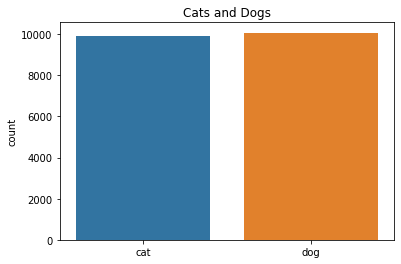

In [0]:
def plot_image_list_count(data_image_list):
    labels = []
    for img in data_image_list:
        labels.append(img.split('.')[-3])
    sns.countplot(labels)
    plt.title('Cats and Dogs')
    
plot_image_list_count(train_image_list)

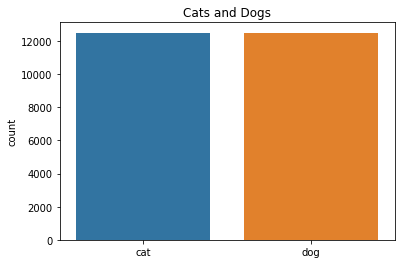

In [0]:
plot_image_list_count(os.listdir(TRAIN_FOLDER))

In [0]:
train = process_data(train_image_list, TRAIN_FOLDER)

100%|██████████| 20000/20000 [01:05<00:00, 307.48it/s]


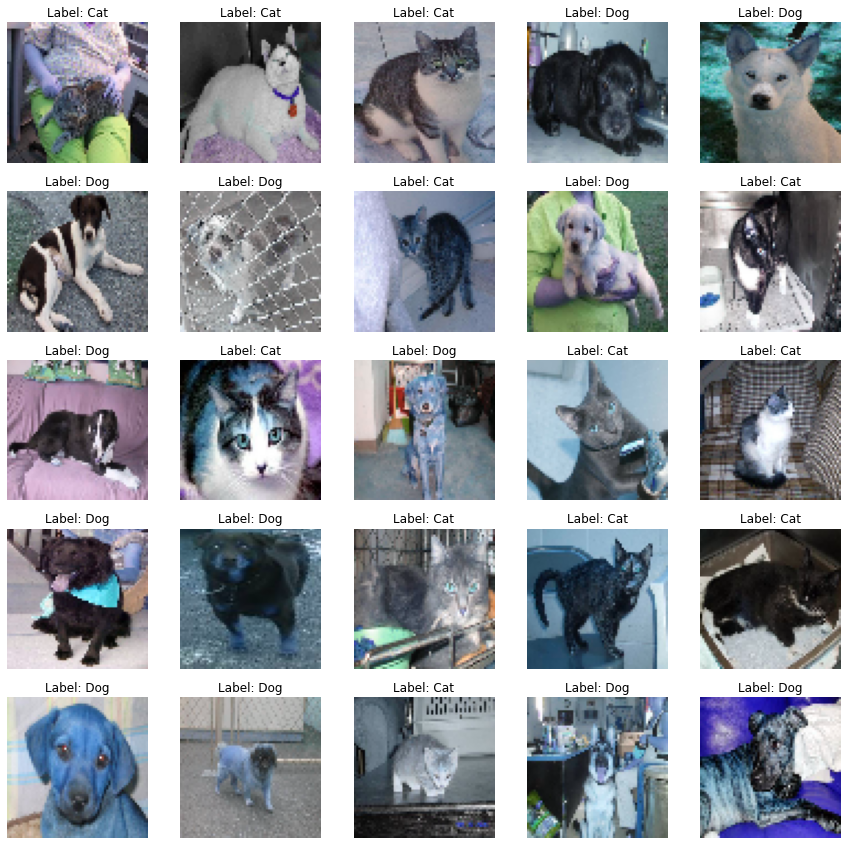

In [0]:
def show_images(data, isTest=False):
    f, ax = plt.subplots(5,5, figsize=(15,15))
    for i,data in enumerate(data[:25]):
        img_num = data[1]
        img_data = data[0]
        label = np.argmax(img_num)
        if label  == 1: 
            str_label='Dog'
        elif label == 0: 
            str_label='Cat'
        if(isTest):
            str_label="None"
        ax[i//5, i%5].imshow(img_data)
        ax[i//5, i%5].axis('off')
        ax[i//5, i%5].set_title("Label: {}".format(str_label))
    plt.show()

show_images(train)

In [0]:
test = process_data(test_image_list, TEST_FOLDER, False)

100%|██████████| 12500/12500 [00:33<00:00, 370.57it/s]


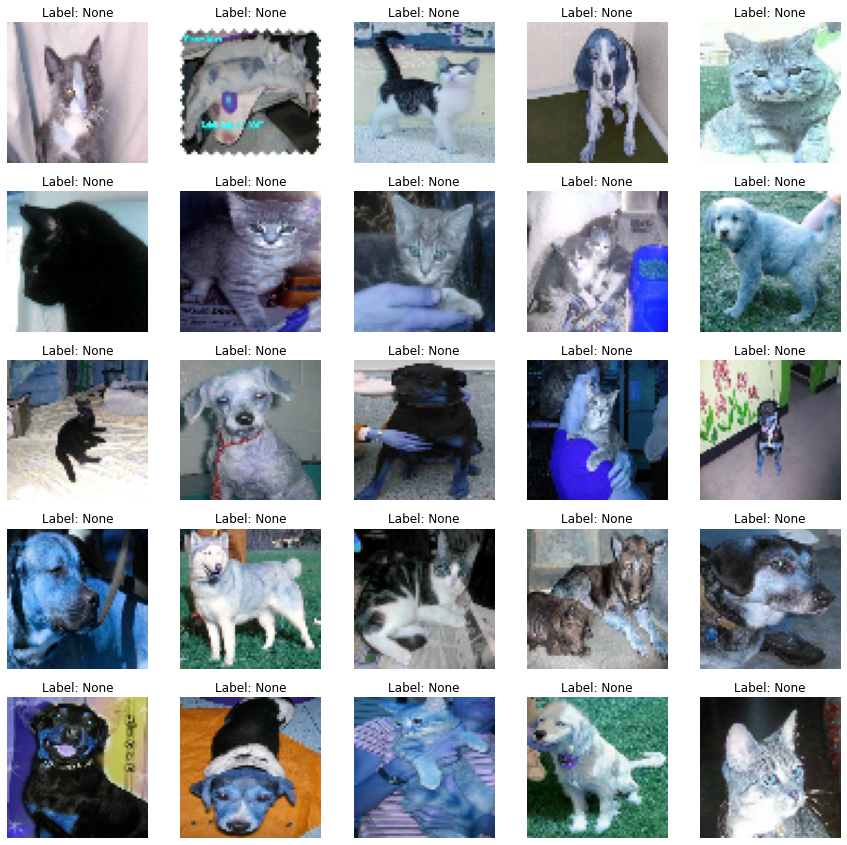

In [0]:
show_images(test,True)

# Make Test and train Data

In [0]:
X = np.array([i[0] for i in train]).reshape(-1,NEW_IMG_SIZE,NEW_IMG_SIZE,3)
y = np.array([i[1] for i in train])

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

# Model 1


In [0]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(NEW_IMG_SIZE, NEW_IMG_SIZE, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten()) #flatten for forecasting
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))

model.layers[0].trainable = True

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 28800)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                1843264   
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)               

In [0]:
train_model = model.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=(X_val, y_val))

Epoch 1/5
625/625 [==============================] - 121s 193ms/step - loss: 0.6898 - accuracy: 0.5466 - val_loss: 0.6867 - val_accuracy: 0.5508
Epoch 2/5
625/625 [==============================] - 121s 193ms/step - loss: 0.6751 - accuracy: 0.5829 - val_loss: 0.6952 - val_accuracy: 0.5520
Epoch 3/5
625/625 [==============================] - 120s 192ms/step - loss: 0.6461 - accuracy: 0.6130 - val_loss: 0.6944 - val_accuracy: 0.5522
Epoch 4/5
625/625 [==============================] - 121s 193ms/step - loss: 0.6059 - accuracy: 0.6471 - val_loss: 0.7079 - val_accuracy: 0.5702
Epoch 5/5
625/625 [==============================] - 123s 197ms/step - loss: 0.5744 - accuracy: 0.6853 - val_loss: 0.7195 - val_accuracy: 0.5820


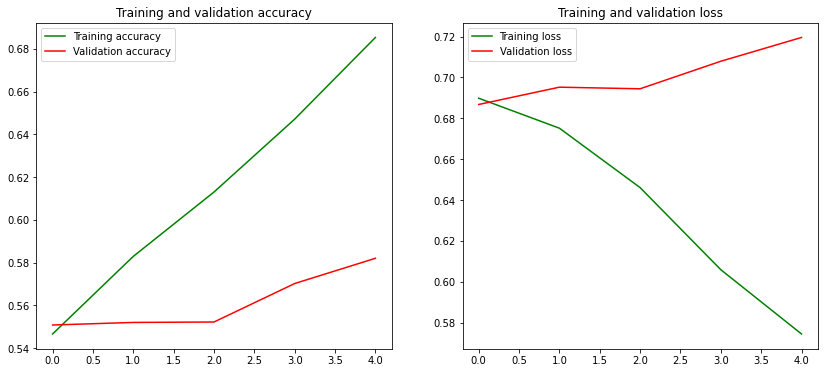

In [0]:
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(len(acc))
    f, ax = plt.subplots(1,2, figsize=(14,6))
    ax[0].plot(epochs, acc, 'g', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    ax[1].plot(epochs, loss, 'g', label='Training loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    plt.show()
plot_accuracy_and_loss(train_model)

In [0]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 0.719534158706665
Validation accuracy: 0.5820000171661377


In [0]:
#get the predictions for the test data
predicted_classes = model.predict_classes(X_val)
#get the indices to be plotted
y_true = np.argmax(y_val,axis=1)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [0]:
correct = np.nonzero(predicted_classes==y_true)[0]
incorrect = np.nonzero(predicted_classes!=y_true)[0]

In [0]:
target_names = ["Class {}:".format(i) for i in range(NUM_CLASSES)]
print(classification_report(y_true, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

    Class 0:       0.56      0.72      0.63      4907
    Class 1:       0.62      0.45      0.53      5093

    accuracy                           0.58     10000
   macro avg       0.59      0.58      0.58     10000
weighted avg       0.59      0.58      0.57     10000



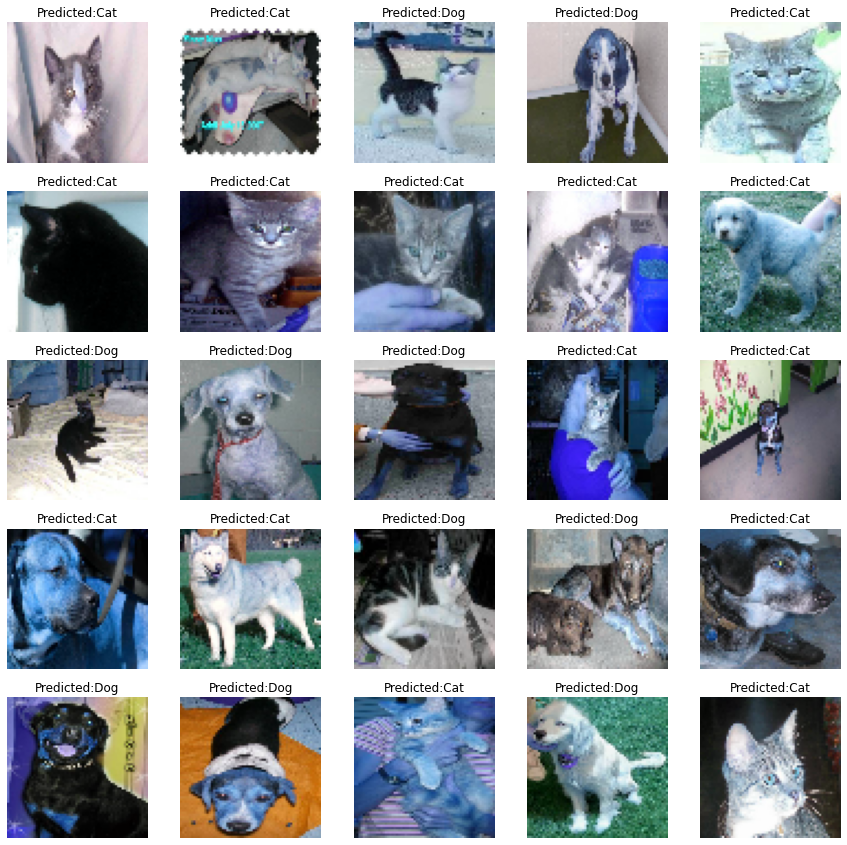

In [0]:
f, ax = plt.subplots(5,5, figsize=(15,15))
for i,data in enumerate(test[:25]):
    img_num = data[1]
    img_data = data[0]
    orig = img_data
    data = img_data.reshape(-1,NEW_IMG_SIZE,NEW_IMG_SIZE,3)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: 
        str_predicted='Dog'
    else: 
        str_predicted='Cat'
    ax[i//5, i%5].imshow(orig)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("Predicted:{}".format(str_predicted))    
plt.show()

# Model 2

In [0]:
model1 = Sequential()
model1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(NEW_IMG_SIZE, NEW_IMG_SIZE, 3)))
model1.add(Conv2D(32, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

model1.add(Flatten()) #flatten for forecasting
model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(NUM_CLASSES, activation='softmax'))

model1.layers[0].trainable = True

model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 26, 26, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 13, 64)       

In [0]:
train_model1 = model1.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=(X_val, y_val))

Epoch 1/5
625/625 [==============================] - 194s 311ms/step - loss: 0.8869 - accuracy: 0.5272 - val_loss: 0.6906 - val_accuracy: 0.5427
Epoch 2/5
625/625 [==============================] - 195s 313ms/step - loss: 0.6925 - accuracy: 0.5231 - val_loss: 0.6925 - val_accuracy: 0.5159
Epoch 3/5
625/625 [==============================] - 194s 311ms/step - loss: 0.6915 - accuracy: 0.5196 - val_loss: 0.6866 - val_accuracy: 0.5447
Epoch 4/5
625/625 [==============================] - 195s 311ms/step - loss: 0.6903 - accuracy: 0.5299 - val_loss: 0.6897 - val_accuracy: 0.5343
Epoch 5/5
625/625 [==============================] - 196s 314ms/step - loss: 0.6938 - accuracy: 0.5265 - val_loss: 0.6921 - val_accuracy: 0.4887


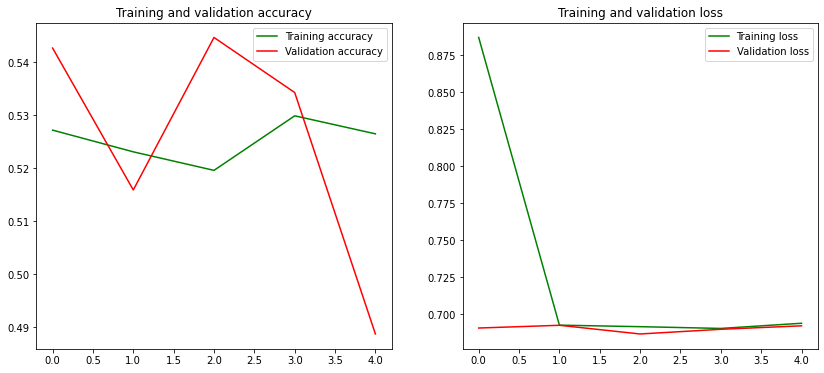

In [0]:
plot_accuracy_and_loss(train_model1)

In [0]:
score = model1.evaluate(X_val, y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 0.6920909881591797
Validation accuracy: 0.4887000024318695


In [0]:
#get the predictions for the test data
predicted_classes = model1.predict_classes(X_val)
#get the indices to be plotted
y_true = np.argmax(y_val,axis=1)

In [0]:
correct = np.nonzero(predicted_classes==y_true)[0]
incorrect = np.nonzero(predicted_classes!=y_true)[0]

In [0]:
target_names = ["Class {}:".format(i) for i in range(NUM_CLASSES)]
print(classification_report(y_true, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

    Class 0:       0.49      0.99      0.66      4907
    Class 1:       0.33      0.00      0.01      5093

    accuracy                           0.49     10000
   macro avg       0.41      0.50      0.33     10000
weighted avg       0.41      0.49      0.33     10000



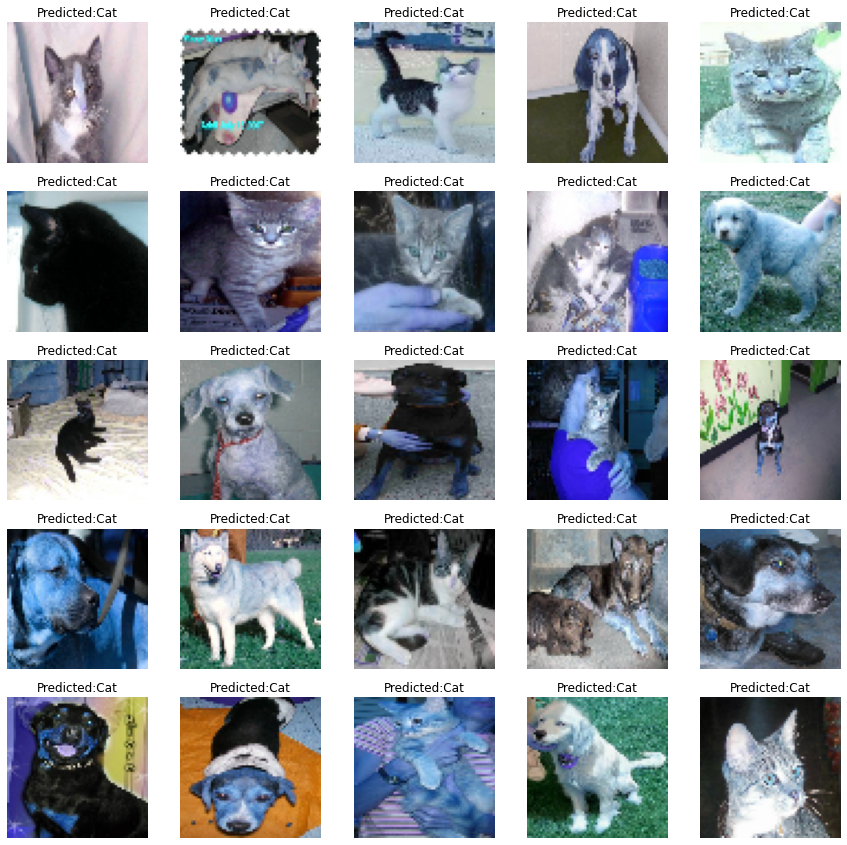

In [0]:
f, ax = plt.subplots(5,5, figsize=(15,15))
for i,data in enumerate(test[:25]):
    img_num = data[1]
    img_data = data[0]
    orig = img_data
    data = img_data.reshape(-1,NEW_IMG_SIZE,NEW_IMG_SIZE,3)
    model_out = model1.predict([data])[0]
    
    if np.argmax(model_out) == 1: 
        str_predicted='Dog'
    else: 
        str_predicted='Cat'
    ax[i//5, i%5].imshow(orig)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("Predicted:{}".format(str_predicted))    
plt.show()

# Model 3

In [0]:
model2 = Sequential()
model2.add(Conv2D(64, (3, 3), activation='relu', input_shape=(NEW_IMG_SIZE, NEW_IMG_SIZE, 3)))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Flatten()) #flatten for forecasting
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(NUM_CLASSES, activation='softmax'))

model2.layers[0].trainable = True

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 62, 62, 64)        1792      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 57600)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               7372928   
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)              

In [0]:
train_model2 = model2.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=(X_val, y_val))

Epoch 1/5
625/625 [==============================] - 310s 497ms/step - loss: 3.0971 - accuracy: 0.5168 - val_loss: 0.6891 - val_accuracy: 0.5369
Epoch 2/5
625/625 [==============================] - 310s 496ms/step - loss: 0.6867 - accuracy: 0.5320 - val_loss: 0.6951 - val_accuracy: 0.4999
Epoch 3/5
625/625 [==============================] - 311s 497ms/step - loss: 0.6711 - accuracy: 0.5555 - val_loss: 0.7028 - val_accuracy: 0.5318
Epoch 4/5
625/625 [==============================] - 312s 498ms/step - loss: 0.6500 - accuracy: 0.5762 - val_loss: 0.7656 - val_accuracy: 0.5366
Epoch 5/5
625/625 [==============================] - 310s 497ms/step - loss: 0.6265 - accuracy: 0.5986 - val_loss: 0.7530 - val_accuracy: 0.5380


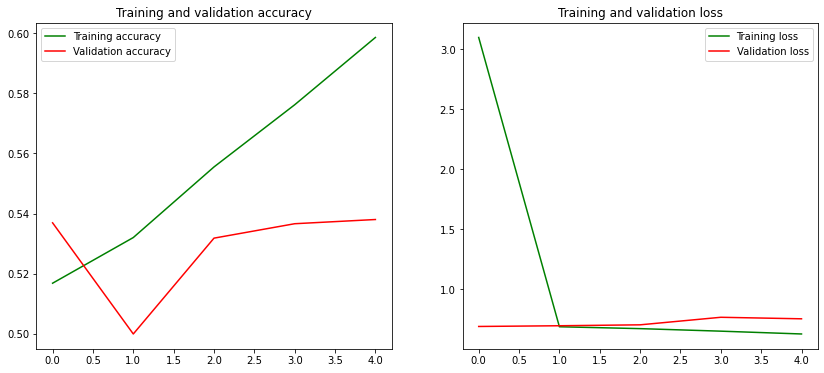

In [0]:
plot_accuracy_and_loss(train_model2)

In [0]:
score = model2.evaluate(X_val, y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 0.7529789805412292
Validation accuracy: 0.5379999876022339


In [0]:
#get the predictions for the test data
predicted_classes = model2.predict_classes(X_val)
#get the indices to be plotted
y_true = np.argmax(y_val,axis=1)

In [0]:
correct = np.nonzero(predicted_classes==y_true)[0]
incorrect = np.nonzero(predicted_classes!=y_true)[0]

In [0]:
target_names = ["Class {}:".format(i) for i in range(NUM_CLASSES)]
print(classification_report(y_true, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

    Class 0:       0.56      0.26      0.35      4907
    Class 1:       0.53      0.81      0.64      5093

    accuracy                           0.54     10000
   macro avg       0.55      0.53      0.50     10000
weighted avg       0.55      0.54      0.50     10000



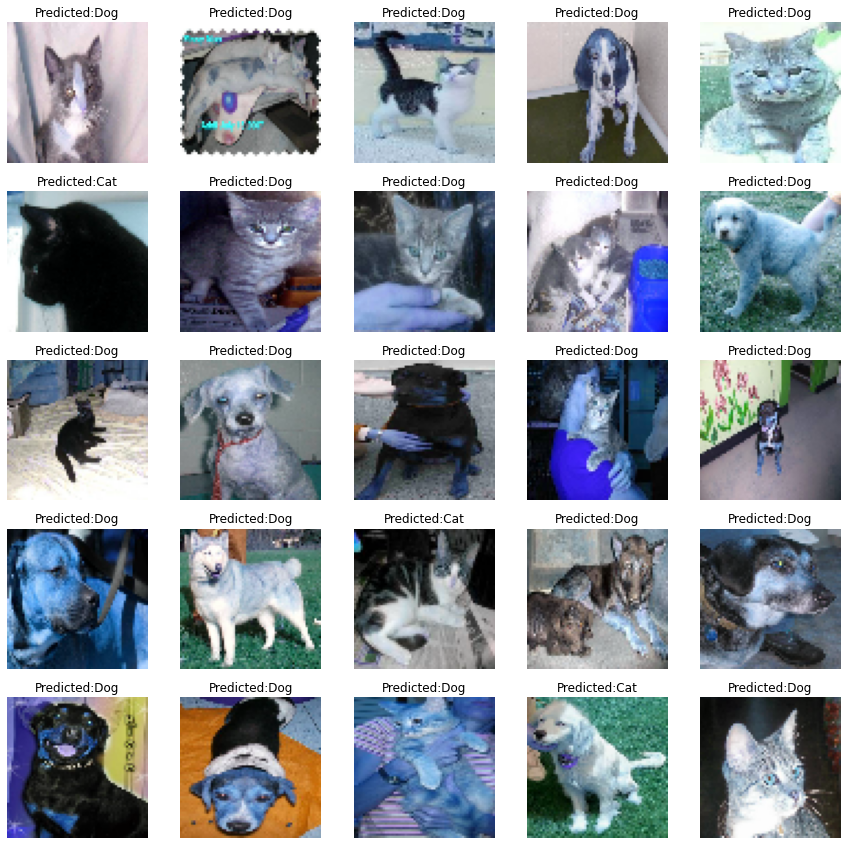

In [0]:
f, ax = plt.subplots(5,5, figsize=(15,15))
for i,data in enumerate(test[:25]):
    img_num = data[1]
    img_data = data[0]
    orig = img_data
    data = img_data.reshape(-1,NEW_IMG_SIZE,NEW_IMG_SIZE,3)
    model_out = model2.predict([data])[0]
    
    if np.argmax(model_out) == 1: 
        str_predicted='Dog'
    else: 
        str_predicted='Cat'
    ax[i//5, i%5].imshow(orig)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("Predicted:{}".format(str_predicted))    
plt.show()

# Model 4

In [0]:
model3 = Sequential()
model3.add(Conv2D(16, (3, 3), activation='relu', input_shape=(NEW_IMG_SIZE, NEW_IMG_SIZE, 3)))
model3.add(Conv2D(16, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))

model3.add(Conv2D(32, (3, 3), activation='relu'))
model3.add(Conv2D(32, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))

model3.add(Flatten()) #flatten for forecasting
model3.add(Dense(64, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(NUM_CLASSES, activation='softmax'))

model3.layers[0].trainable = True

model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model3.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 62, 62, 16)        448       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 60, 60, 16)        2320      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 28, 28, 32)        4640      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 26, 26, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 13, 13, 32)       

In [0]:
train_model3 = model3.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=(X_val, y_val))

Epoch 1/5
625/625 [==============================] - 87s 140ms/step - loss: 2.2389 - accuracy: 0.5126 - val_loss: 0.6934 - val_accuracy: 0.4906
Epoch 2/5
625/625 [==============================] - 87s 140ms/step - loss: 0.6938 - accuracy: 0.5073 - val_loss: 0.6925 - val_accuracy: 0.5314
Epoch 3/5
625/625 [==============================] - 88s 140ms/step - loss: 0.6916 - accuracy: 0.5045 - val_loss: 0.6933 - val_accuracy: 0.4907
Epoch 4/5
625/625 [==============================] - 88s 140ms/step - loss: 0.6933 - accuracy: 0.4975 - val_loss: 0.6932 - val_accuracy: 0.4906
Epoch 5/5
625/625 [==============================] - 88s 141ms/step - loss: 0.6928 - accuracy: 0.4982 - val_loss: 0.6931 - val_accuracy: 0.5133


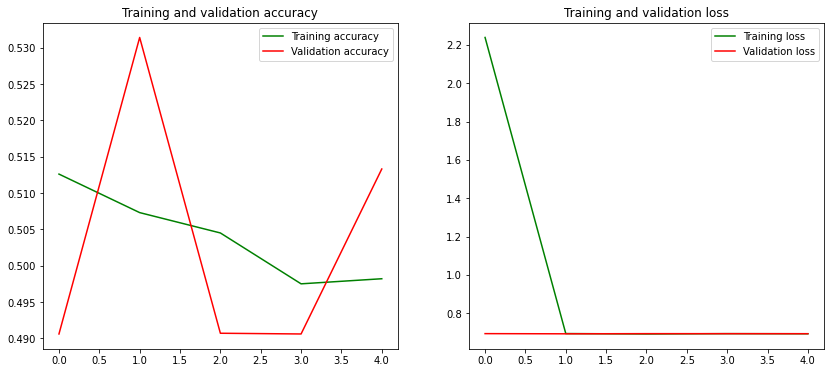

In [0]:
plot_accuracy_and_loss(train_model3)

In [0]:
score = model3.evaluate(X_val, y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 0.6930745244026184
Validation accuracy: 0.5133000016212463


In [0]:
#get the predictions for the test data
predicted_classes = model3.predict_classes(X_val)
#get the indices to be plotted
y_true = np.argmax(y_val,axis=1)

In [0]:
correct = np.nonzero(predicted_classes==y_true)[0]
incorrect = np.nonzero(predicted_classes!=y_true)[0]

In [0]:
target_names = ["Class {}:".format(i) for i in range(NUM_CLASSES)]
print(classification_report(y_true, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

    Class 0:       0.74      0.01      0.02      4907
    Class 1:       0.51      1.00      0.68      5093

    accuracy                           0.51     10000
   macro avg       0.63      0.50      0.35     10000
weighted avg       0.63      0.51      0.36     10000



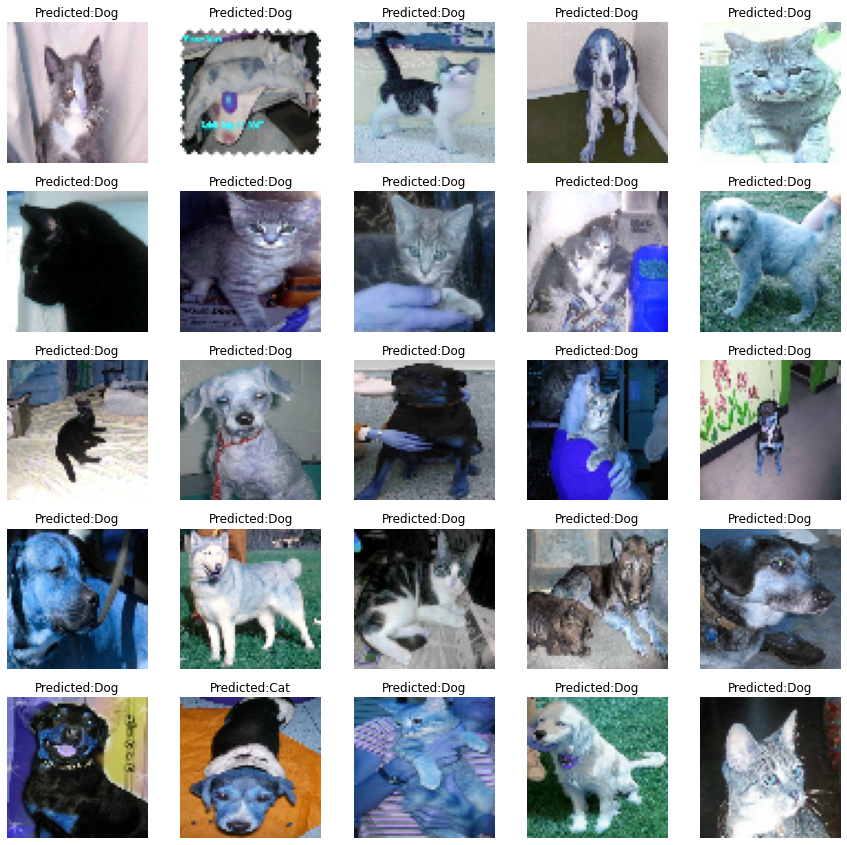

In [0]:
f, ax = plt.subplots(5,5, figsize=(15,15))
for i,data in enumerate(test[:25]):
    img_num = data[1]
    img_data = data[0]
    orig = img_data
    data = img_data.reshape(-1,NEW_IMG_SIZE,NEW_IMG_SIZE,3)
    model_out = model3.predict([data])[0]
    
    if np.argmax(model_out) == 1: 
        str_predicted='Dog'
    else: 
        str_predicted='Cat'
    ax[i//5, i%5].imshow(orig)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("Predicted:{}".format(str_predicted))    
plt.show()

#Testing Data and Submissions

In [0]:
pred_list = []
img_list = []
for img in tqdm(test):
    img_data = img[0]
    img_idx = img[1]
    data = img_data.reshape(-1,NEW_IMG_SIZE,NEW_IMG_SIZE,3)
    predicted = model.predict([data])[0]
    img_list.append(img_idx)
    pred_list.append(predicted[1])

100%|██████████| 12500/12500 [06:29<00:00, 32.07it/s]


In [0]:
submission = pd.DataFrame({'id':img_list , 'label':pred_list})
submission.head()
submission.to_csv("Final submission1 Assignment 7.csv", index=False)

In [0]:
pred_list = []
img_list = []
for img in tqdm(test):
    img_data = img[0]
    img_idx = img[1]
    data = img_data.reshape(-1,NEW_IMG_SIZE,NEW_IMG_SIZE,3)
    predicted = model1.predict([data])[0]
    img_list.append(img_idx)
    pred_list.append(predicted[1])

100%|██████████| 12500/12500 [06:52<00:00, 30.30it/s]


In [0]:
submission = pd.DataFrame({'id':img_list , 'label':pred_list})
submission.head()
submission.to_csv("submission2 Assignment 7.csv", index=False)

In [0]:
pred_list = []
img_list = []
for img in tqdm(test):
    img_data = img[0]
    img_idx = img[1]
    data = img_data.reshape(-1,NEW_IMG_SIZE,NEW_IMG_SIZE,3)
    predicted = model2.predict([data])[0]
    img_list.append(img_idx)
    pred_list.append(predicted[1])

100%|██████████| 12500/12500 [07:46<00:00, 26.78it/s]


In [0]:
submission = pd.DataFrame({'id':img_list , 'label':pred_list})
submission.head()
submission.to_csv("submission3 Assignment 7.csv", index=False)

In [0]:
pred_list = []
img_list = []
for img in tqdm(test):
    img_data = img[0]
    img_idx = img[1]
    data = img_data.reshape(-1,NEW_IMG_SIZE,NEW_IMG_SIZE,3)
    predicted = model3.predict([data])[0]
    img_list.append(img_idx)
    pred_list.append(predicted[1])

100%|██████████| 12500/12500 [06:34<00:00, 31.72it/s]


In [0]:
submission = pd.DataFrame({'id':img_list , 'label':pred_list})
submission.head()
submission.to_csv("submission4 Assignment 7.csv", index=False)